In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# -------------------------------------------------------
# 1. Dataset Class
# -------------------------------------------------------

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            class_folder = os.path.join(root_dir, cls)
            if not os.path.isdir(class_folder):
                continue
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.image_paths.append(img_path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label



In [9]:
# -------------------------------------------------------
# 2. Load Dataset
# -------------------------------------------------------

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

dataset_path = "data/Training"   # change to Testing if needed
dataset = BrainTumorDataset(dataset_path, transform=transform)

print(f"Total images: {len(dataset)}")
print("Classes:", dataset.classes)

test_dataset_path = "data/Testing"
test_dataset = BrainTumorDataset(test_dataset_path, transform=transform)



Total images: 5712
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


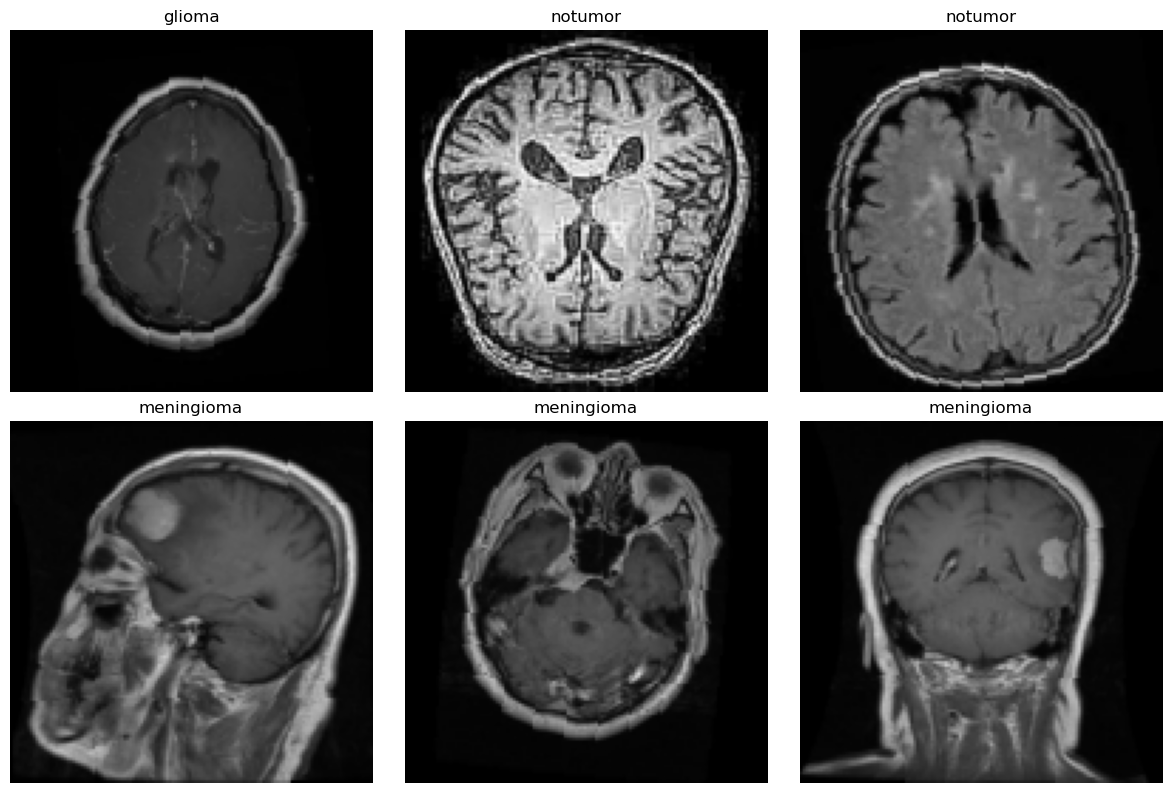

In [10]:
# -------------------------------------------------------
# 3. Display Random Images
# -------------------------------------------------------

def show_random_images(dataset, num_images=6):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        idx = random.randint(0, len(dataset)-1)
        image, label = dataset[idx]

        # Convert tensor → numpy image
        print(image.shape)
        image_np = image.permute(1,2,0).numpy()

        plt.subplot(2, 3, i+1)
        plt.imshow(image_np)
        plt.title(dataset.classes[label])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(dataset, num_images=6)

In [11]:
trainloader = DataLoader(dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_network(nn.Module):
    def __init__(self):
        super(CNN_network, self).__init__()
        
        # 1. Convolutional Block
        # Reminder: If your MRI data is grayscale, change the '3' below to '1'.
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.dropout = nn.Dropout(0.25)
        
        # 2. Fully Connected Block
        # CORRECTED INPUT SIZE: 16 * 64 * 64 = 65,536 (Matches the 128x128 data)
        self.fc1 = nn.Linear(16 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 64)  # Input 65536 -> 128 hidden neurons
        self.fc3 = nn.Linear(64, 4)            # 128 -> 4 classes

    def forward(self, x):
        # Convolution and Pooling
        x = self.pool(F.relu(self.conv1(x)))
        
        # Flattening: x.size(0) preserves the batch size (which is 8)
        x = x.view(x.size(0), -1) 
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

⬇️ Start Training with Gradient Descent...

Epoch 1 Completed — Average Loss: 0.8331
Epoch 2 Completed — Average Loss: 0.5288
Epoch 3 Completed — Average Loss: 0.4408
Epoch 4 Completed — Average Loss: 0.4109
Epoch 5 Completed — Average Loss: 0.3413
Epoch 6 Completed — Average Loss: 0.3258
Epoch 7 Completed — Average Loss: 0.2877
Epoch 8 Completed — Average Loss: 0.2726
Epoch 9 Completed — Average Loss: 0.2661
Epoch 10 Completed — Average Loss: 0.2357

✅ Finished Training


📉 GRADIENT DESCENT EXPLANATION:
- Each point is the loss after a batch.
- The optimizer adjusts weights to move downhill.
- The smoothed curve shows the overall descent.

⚡ LR EXPLANATION:
- LR controls how big each step of gradient descent is.
- High LR = bigger jumps; Low LR = smaller, precise steps.


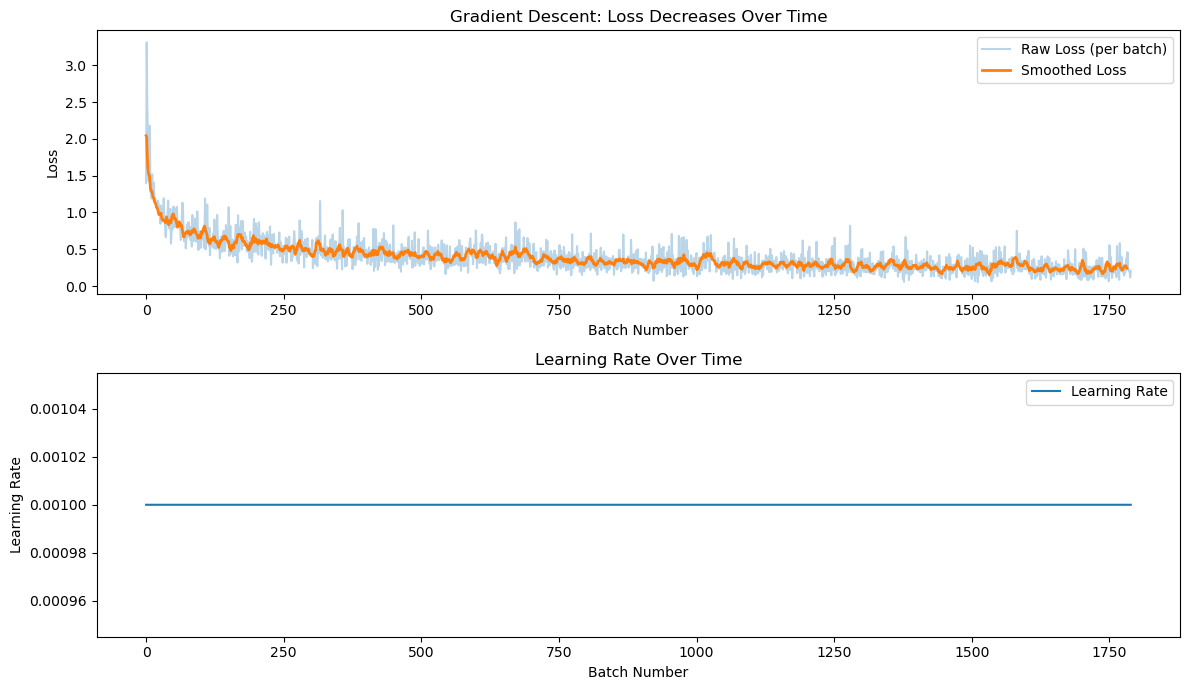

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


# -----------------------------------------------------------------------
# Improved loss plotting function that explains gradient descent behavior
# -----------------------------------------------------------------------
def plot_training_progress(loss_history, lr_history):
    """
    Shows:
    - Raw loss per batch (noisy curve)
    - Smoothed loss curve (true descent trend)
    - Learning rate per batch
    """

    if not loss_history:
        print("No loss data recorded.")
        return

    # Convert to numpy for easier processing
    loss_history = np.array(loss_history)
    lr_history = np.array(lr_history)

    # Smooth loss curve – moving average
    window = max(5, len(loss_history) // 200)
    smooth_loss = np.convolve(loss_history, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(12, 7))

    # -----------------------------
    # Plot 1 — Loss curve (Gradient Descent visualization)
    # -----------------------------
    plt.subplot(2, 1, 1)
    plt.plot(loss_history, alpha=0.3, label="Raw Loss (per batch)")
    plt.plot(np.arange(len(smooth_loss)), smooth_loss, linewidth=2, label="Smoothed Loss")

    plt.title("Gradient Descent: Loss Decreases Over Time")
    plt.xlabel("Batch Number")
    plt.ylabel("Loss")
    plt.legend()

    # Explanation for beginners
    print("\n📉 GRADIENT DESCENT EXPLANATION:")
    print("- Each point is the loss after a batch.")
    print("- The optimizer adjusts weights to move downhill.")
    print("- The smoothed curve shows the overall descent.")

    # -----------------------------
    # Plot 2 — Learning rate curve
    # -----------------------------
    plt.subplot(2, 1, 2)
    plt.plot(lr_history, label="Learning Rate")
    plt.title("Learning Rate Over Time")
    plt.xlabel("Batch Number")
    plt.ylabel("Learning Rate")
    plt.legend()

    print("\n⚡ LR EXPLANATION:")
    print("- LR controls how big each step of gradient descent is.")
    print("- High LR = bigger jumps; Low LR = smaller, precise steps.")

    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------------
# TRAINING CODE — rewritten to clearly explain gradient descent
# -----------------------------------------------------------------------

criterion = nn.CrossEntropyLoss()
model = CNN_network()

# Adam controls the learning rate dynamically each batch
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("mps")
model.to(device)

loss_history = []
lr_history = []  # Track learning rate each batch (Adam changes internally)

print("⬇️ Start Training with Gradient Descent...\n")

for epoch in range(10):
    running_loss = 0.0
    model.train()

    for i, (images, labels) in enumerate(trainloader):

        images, labels = images.to(device), labels.to(device)

        # 1. RESET GRADIENTS
        optimizer.zero_grad()

        # 2. FORWARD PASS — model makes prediction
        outputs = model(images)

        # 3. COMPUTE LOSS — measures how wrong predictions are
        loss = criterion(outputs, labels)

        # Save the loss
        loss_history.append(loss.item())

        # Save current LR for visualization
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)

        # 4. BACKWARD PASS — compute gradients for all parameters
        loss.backward()

        # 5. UPDATE WEIGHTS — gradient descent step
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Completed — Average Loss: {running_loss/len(trainloader):.4f}")

print("\n✅ Finished Training\n")

plot_training_progress(loss_history, lr_history)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

class CNN_network(nn.Module):
    def __init__(self, activation="relu"):
        super(CNN_network, self).__init__()

        self.activation_fn = {
            "relu": F.relu,
            "tanh": torch.tanh,
            "sigmoid": torch.sigmoid,
            "leaky_relu": F.leaky_relu,
        }[activation]

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(16 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)

        self.feature_maps = []

    def forward(self, x):
        x = self.conv1(x)
        self.feature_maps.append(x.detach().cpu())
        x = self.pool(self.activation_fn(x))

        x = x.view(x.size(0), -1)

        x = self.activation_fn(self.fc1(x))
        x = self.dropout(x)
        x = self.activation_fn(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


def plot_feature_maps(feature_maps):
    fmap = feature_maps[0][0]
    num_maps = fmap.shape[0]
    cols = 8
    rows = num_maps // cols

    plt.figure(figsize=(15, 8))
    for i in range(num_maps):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(fmap[i], cmap='gray')
        plt.axis('off')
    plt.show()


def calculate_metrics(labels, preds):
    cm = confusion_matrix(labels, preds)
    TN, FP, FN, TP = cm.ravel() if cm.size == 4 else (None, None, None, None)
    accuracy = np.mean(labels == preds)
    return cm, accuracy, (TN, FP, FN, TP)


def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


def plot_roc_curve(true_labels, probs, num_classes):
    plt.figure(figsize=(8, 6))
    for c in range(num_classes):
        fpr, tpr, _ = roc_curve(true_labels == c, probs[:, c])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {c} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# -------------------- TRAINING + VALIDATION LOOP --------------------
def train_model(model, trainloader, testloader, device, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history = []
    val_history = []
    lr_history = []

    all_preds = []
    all_labels = []
    all_probs = []

    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loss_history.append(loss.item())
            lr_history.append(optimizer.param_groups[0]['lr'])

        # ---------------- VALIDATION ----------------
        model.eval()
        preds = []
        labels_list = []
        probs = []

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                prob = F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                preds.extend(predicted.cpu().numpy())
                labels_list.extend(labels.cpu().numpy())
                probs.extend(prob.cpu().numpy())

        # Track metrics
        all_preds = preds
        all_labels = labels_list
        all_probs = np.array(probs)

        acc = np.mean(np.array(preds) == np.array(labels_list))
        val_history.append(acc)

        print(f"Epoch {epoch+1}/{epochs} — Loss: {running_loss/len(trainloader):.4f}, Val Accuracy: {acc:.4f}")

    return loss_history, lr_history, val_history, all_preds, all_labels, all_probs

metrics = train_model(model, trainloader, testloader, device)

Epoch 1/10 — Loss: 0.1551, Val Accuracy: 0.9314
Epoch 2/10 — Loss: 0.1406, Val Accuracy: 0.9375
Epoch 3/10 — Loss: 0.1223, Val Accuracy: 0.9466
Epoch 4/10 — Loss: 0.1249, Val Accuracy: 0.9382
Epoch 5/10 — Loss: 0.1091, Val Accuracy: 0.9527
Epoch 6/10 — Loss: 0.1210, Val Accuracy: 0.9336
Epoch 7/10 — Loss: 0.1208, Val Accuracy: 0.9458
Epoch 8/10 — Loss: 0.1115, Val Accuracy: 0.9497
Epoch 9/10 — Loss: 0.1036, Val Accuracy: 0.9542
Epoch 10/10 — Loss: 0.1002, Val Accuracy: 0.9512


([0.09621210396289825, 0.30314725637435913, 0.21828648447990417, 0.03406992182135582, 0.05134289711713791, 0.11122678220272064, 0.16734609007835388, 0.19124551117420197, 0.07384227216243744, 0.006273236591368914, 0.07652188837528229, 0.19419410824775696, 0.11447353661060333, 0.03567221760749817, 0.2058473527431488, 0.14060664176940918, 0.1523216813802719, 0.02663121372461319, 0.3264668583869934, 0.272771418094635, 0.1418265700340271, 0.27820995450019836, 0.08135466277599335, 0.2585853040218353, 0.12973041832447052, 0.33431553840637207, 0.2436595857143402, 0.16124576330184937, 0.2417444884777069, 0.18554948270320892, 0.25751984119415283, 0.08722053468227386, 0.2491704225540161, 0.09460893273353577, 0.10654038190841675, 0.10455285012722015, 0.15900959074497223, 0.19567498564720154, 0.11391164362430573, 0.16779819130897522, 0.3747725188732147, 0.15993645787239075, 0.11513706296682358, 0.1111728698015213, 0.2896890640258789, 0.43338435888290405, 0.29997387528419495, 0.08984142541885376, 0.

Running on device: mps
--- Starting Training: relu ---
Epoch 1/5 | Loss: 0.8360 | Val Acc: 0.7300
Epoch 2/5 | Loss: 0.5463 | Val Acc: 0.7674
Epoch 3/5 | Loss: 0.4672 | Val Acc: 0.8230
Epoch 4/5 | Loss: 0.4114 | Val Acc: 0.8223
Epoch 5/5 | Loss: 0.3670 | Val Acc: 0.8055

Visualizing Results for: relu


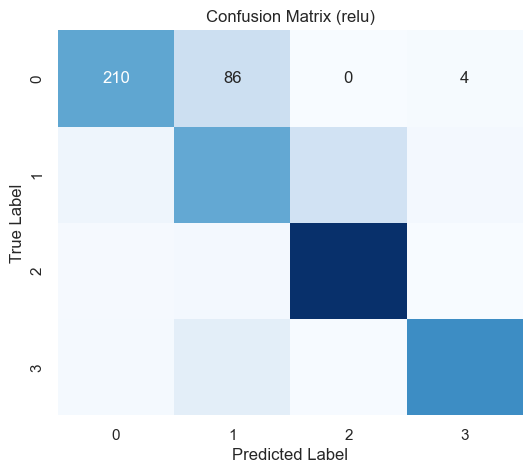

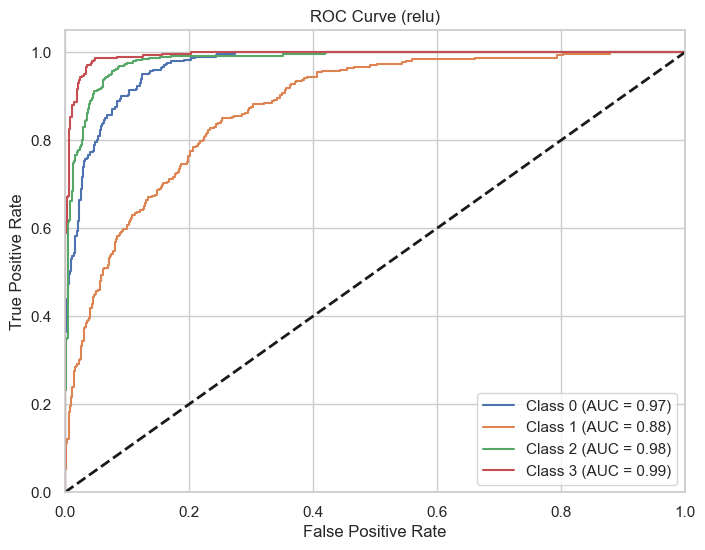

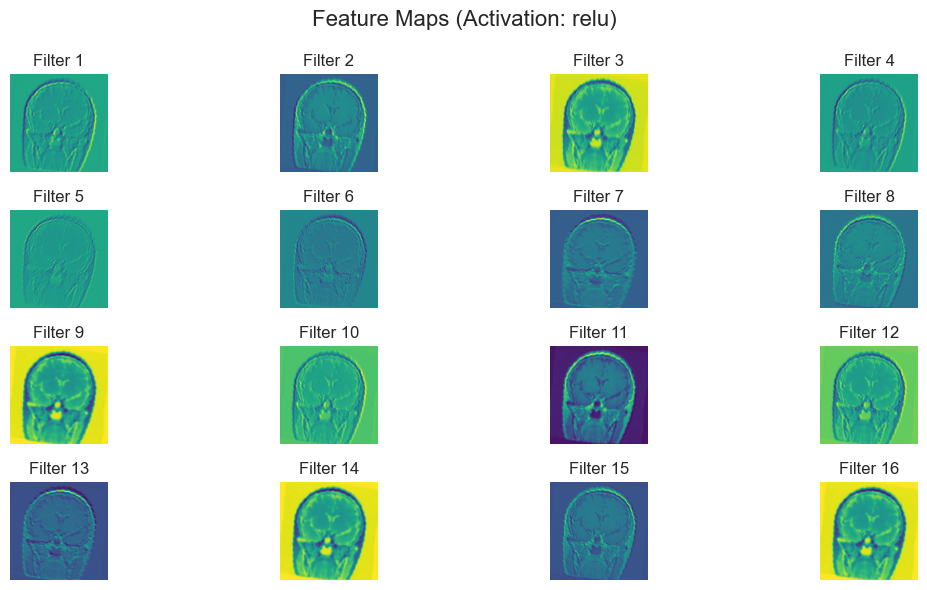

--- Starting Training: sigmoid ---
Epoch 1/5 | Loss: 1.4001 | Val Acc: 0.3089
Epoch 2/5 | Loss: 1.3922 | Val Acc: 0.3089
Epoch 3/5 | Loss: 1.3868 | Val Acc: 0.3089
Epoch 4/5 | Loss: 1.3872 | Val Acc: 0.3089
Epoch 5/5 | Loss: 1.3865 | Val Acc: 0.3089

Visualizing Results for: sigmoid


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


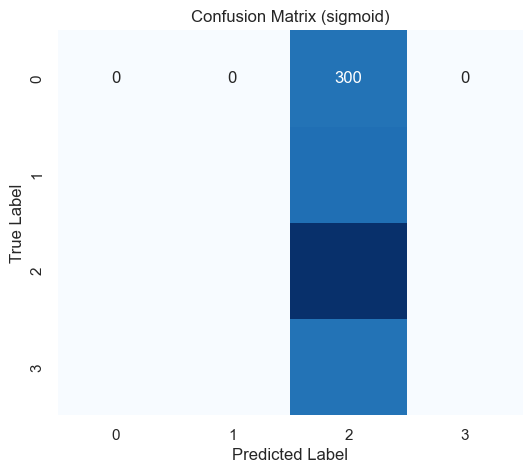

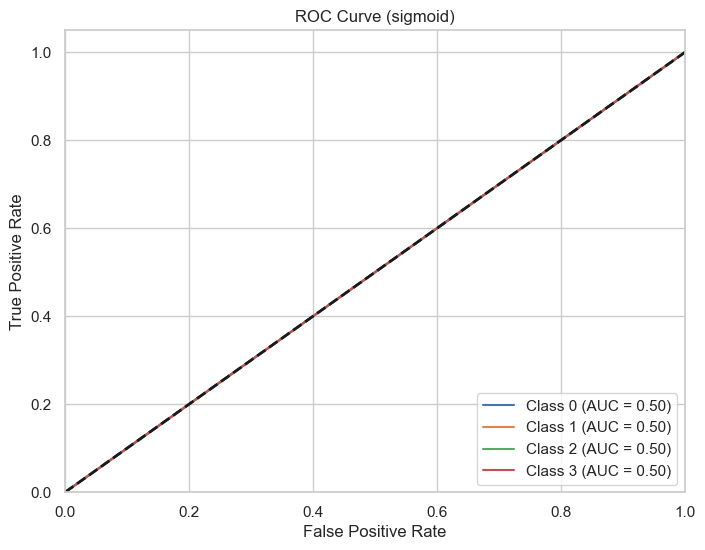

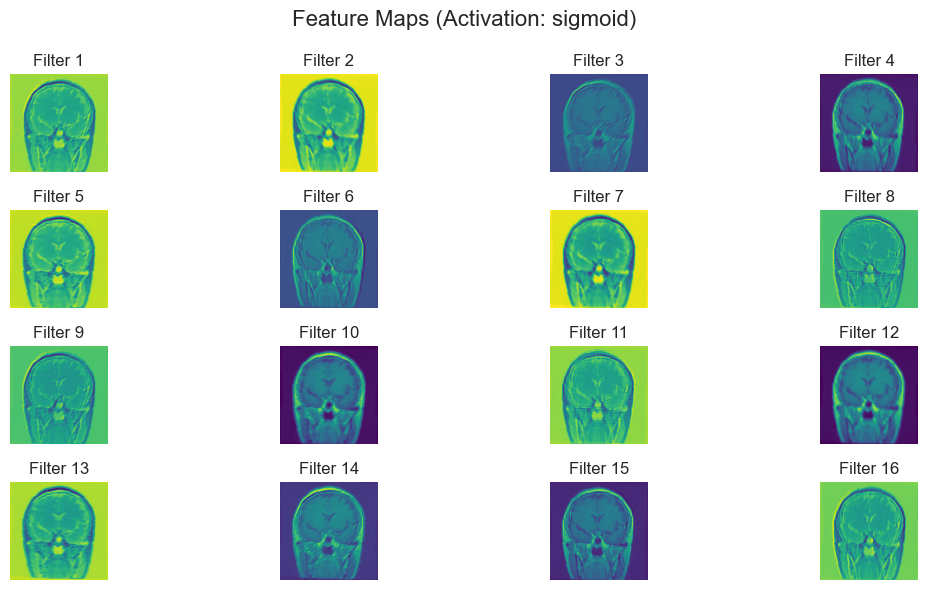

--- Starting Training: leaky_relu ---
Epoch 1/5 | Loss: 0.7869 | Val Acc: 0.7613
Epoch 2/5 | Loss: 0.4921 | Val Acc: 0.8093
Epoch 3/5 | Loss: 0.3935 | Val Acc: 0.8299
Epoch 4/5 | Loss: 0.3328 | Val Acc: 0.8330
Epoch 5/5 | Loss: 0.3024 | Val Acc: 0.8680

Visualizing Results for: leaky_relu


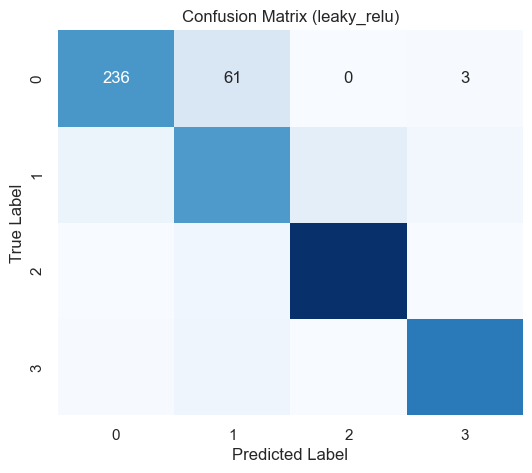

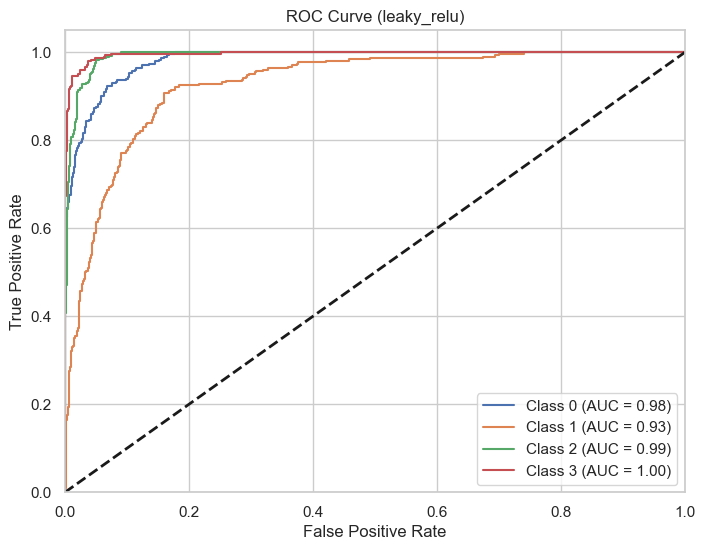

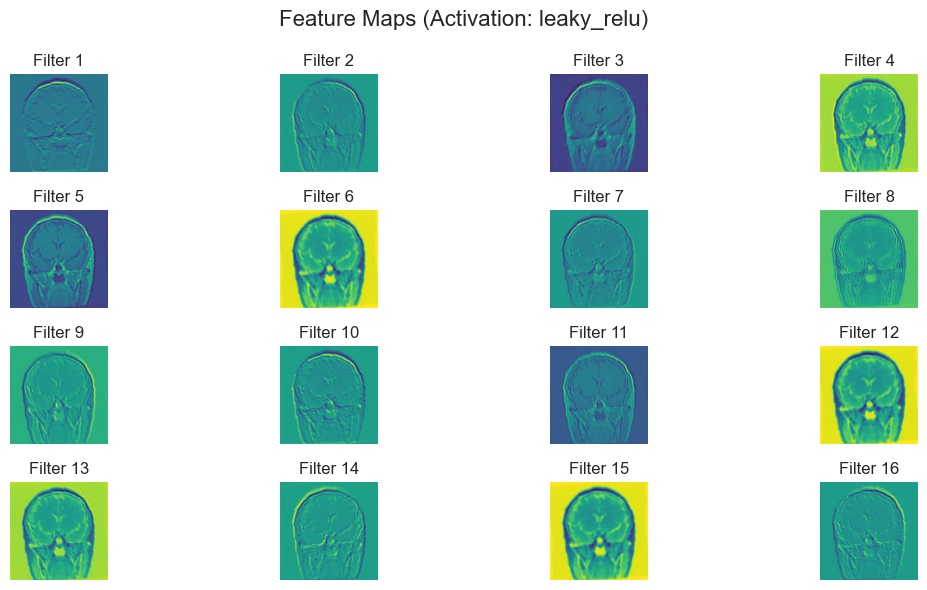

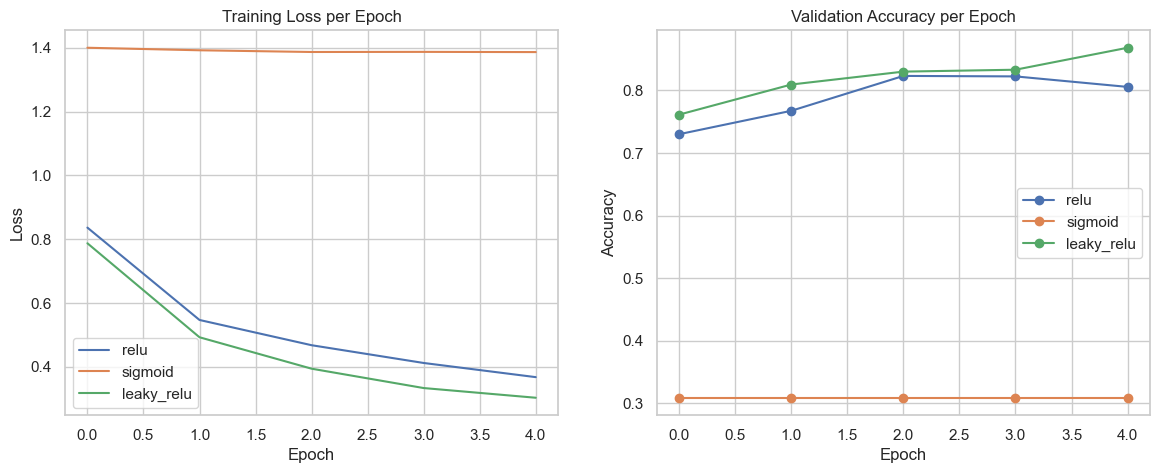

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize

# Set style for plots
sns.set(style="whitegrid")

# -------------------- 1. MODEL DEFINITION --------------------
class CNN_network(nn.Module):
    def __init__(self, activation="relu", num_classes=4, input_shape=(3, 128, 128)):
        super(CNN_network, self).__init__()
        
        # Activation Dictionary
        self.activation_name = activation
        self.activation_fn = {
            "relu": F.relu,
            "tanh": torch.tanh,
            "sigmoid": torch.sigmoid,
            "leaky_relu": F.leaky_relu,
        }[activation]

        # Layers
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        
        # Dynamically calculate the flattened size for the linear layer
        # Output of conv1 (same spatial due to padding) -> Pool (spatial / 2)
        # 16 channels * (H/2) * (W/2)
        final_h = input_shape[1] // 2
        final_w = input_shape[2] // 2
        flattened_size = 16 * final_h * final_w
        
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

        # Store only the latest feature map to prevent memory leaks
        self.latest_feature_map = None

    def forward(self, x):
        # Convolution Block
        x = self.conv1(x)
        
        # Store feature map for visualization (detach to save memory)
        self.latest_feature_map = x.detach().cpu()
        
        x = self.activation_fn(x)
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected Blocks
        x = self.activation_fn(self.fc1(x))
        x = self.dropout(x)
        x = self.activation_fn(self.fc2(x))
        x = self.dropout(x)
        
        # Output Layer (Raw logits, no Softmax here as CrossEntropyLoss handles it)
        x = self.fc3(x)
        return x

# -------------------- 2. VISUALIZATION & METRICS TOOLS --------------------
#[Image of CNN feature extraction]

def plot_feature_maps(model):
    """Plots the feature maps of the first layer from the last forward pass."""
    if model.latest_feature_map is None:
        print("No feature maps found. Run a forward pass first.")
        return

    fmap = model.latest_feature_map[0] # Take first image in batch
    num_maps = fmap.shape[0]
    
    # Grid calculation
    cols = 4
    rows = int(np.ceil(num_maps / cols))

    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Feature Maps (Activation: {model.activation_name})", fontsize=16)
    
    for i in range(num_maps):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(fmap[i], cmap='viridis') # Viridis is often better for heatmaps
        plt.axis('off')
        plt.title(f"Filter {i+1}")
    plt.tight_layout()
    plt.show()

def calculate_metrics(labels, preds, classes):
    """Calculates accuracy and generates a classification report."""
    cm = confusion_matrix(labels, preds)
    accuracy = np.mean(np.array(labels) == np.array(preds))
    
    # Check if binary or multi-class for detailed report
    if len(classes) == 2:
        # If binary, we can extract TN, FP etc easily, but we'll stick to generic report
        pass
    
    report = classification_report(labels, preds, target_names=[f"Class {c}" for c in classes], output_dict=True)
    return cm, accuracy, report

def plot_confusion_matrix(cm, activation_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix ({activation_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def plot_roc_curve(true_labels, probs, num_classes, activation_name):
    """Plots ROC curves for multi-class via One-vs-Rest approach."""
    # Binarize labels for multi-class ROC
    y_test_bin = label_binarize(true_labels, classes=range(num_classes))
    
    plt.figure(figsize=(8, 6))
    for c in range(num_classes):
        # Handle edge cases where a class might not be present in the batch
        if np.sum(y_test_bin[:, c]) > 0: 
            fpr, tpr, _ = roc_curve(y_test_bin[:, c], probs[:, c])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class {c} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({activation_name})")
    plt.legend(loc="lower right")
    plt.show()

# -------------------- 3. TRAINING ENGINE --------------------
def train_model(model, trainloader, testloader, device, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history = [] 
    val_acc_history = []
    
    model.to(device)

    print(f"--- Starting Training: {model.activation_name} ---")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        # Average loss per epoch
        epoch_loss = running_loss / len(trainloader)
        loss_history.append(epoch_loss)

        # ---------------- VALIDATION ----------------
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                # Softmax for probabilities
                probs = F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        # Calculate Validation Accuracy
        acc = np.mean(np.array(all_preds) == np.array(all_labels))
        val_acc_history.append(acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Val Acc: {acc:.4f}")

    return {
        "loss": loss_history,
        "val_acc": val_acc_history,
        "preds": np.array(all_preds),
        "labels": np.array(all_labels),
        "probs": np.array(all_probs)
    }

# -------------------- 4. COMPARISON DRIVER --------------------
def compare_activations(activations, trainloader, testloader, device, epochs=5):
    results = {}
    
    # 1. Train and Collect Data
    for act in activations:
        model = CNN_network(activation=act, num_classes=4, input_shape=(3, 128, 128))
        
        data = train_model(model, trainloader, testloader, device, epochs=epochs)
        
        # Calculate final metrics
        cm, acc, report = calculate_metrics(data["labels"], data["preds"], classes=[0,1,2,3])
        
        results[act] = {
            **data, # Unpack history, preds, etc.
            "cm": cm,
            "final_acc": acc
        }
        
        # Immediate Visualization per model
        print(f"\nVisualizing Results for: {act}")
        plot_confusion_matrix(cm, act)
        plot_roc_curve(data["labels"], data["probs"], num_classes=4, activation_name=act)
        
        # Visualize feature maps for the very last batch
        plot_feature_maps(model)

    # 2. Compare Training Curves
    plt.figure(figsize=(14, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    for act in results:
        plt.plot(results[act]["loss"], label=f"{act}")
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for act in results:
        plt.plot(results[act]["val_acc"], marker='o', label=f"{act}")
    plt.title("Validation Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

# -------------------- MAIN EXECUTION --------------------
if __name__ == "__main__":
    # Configuration
    DEVICE = torch.device("mps")
    EPOCHS = 5
    ACTIVATIONS_TO_COMPARE = ["relu", "sigmoid", "leaky_relu"]
    
    print(f"Running on device: {DEVICE}")
    
    # 1. Get Data
    
    # 2. Run Comparison
    compare_activations(ACTIVATIONS_TO_COMPARE, trainloader, testloader, DEVICE, EPOCHS)